# Generating tables and plots for the paper

The code in this notebook generates Tables 4 and 5, Figures 5 and 6 in our paper on [Provenance Graph Kernel](https://arxiv.org/abs/2010.10343). It is run automatically as part of the evaluation pipeline (`make plots`).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
sns.set_context("paper")

## Loading scoring and timing data

In [2]:
def load_scoring(dataset_id) -> pd.DataFrame:
    outputs_folder = Path("outputs") / dataset_id
    output_filepath = outputs_folder / "scoring.pickled"
    
    results = pd.read_pickle(output_filepath)
    
    return results

In [3]:
# Identifiers for the six datasets
dataset_ids = ["MIMIC-PXC7", "CM-Buildings", "CM-Routes", "CM-RouteSets", "PG-T", "PG-D"]
dataset_names = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]

In [4]:
# The following graph kernels are in the "slow" group
slow_GKs = {
    "GK-GSamp",
    "GK-NSPD",
    "GK-NH",
    "GK-SPath",
    "GK-WL-OA-1",
    "GK-WL-OA-2",
    "GK-WL-OA-3",
    "GK-WL-OA-4",
    "GK-WL-OA-5",
}

def name_group(method: str) -> str:
    if method in slow_GKs:
        return "GK-slow"
    elif method.startswith("GK-"):
        # all other graph kernels are in the "fast" group
        return "GK-fast"
    elif method.startswith("PNA-"):
        # Provenance Network Analytics method
        return "PNA"
    elif method.startswith("FG-"):
        # provenance kernels using generic PROV types
        return "PK-G"
    elif method.startswith("FA-"):
        # provenance kernels using generic PROV types and application types
        return "PK-A"
    else:
        return "AppData"

def best_performers(results: pd.DataFrame, scoring="accuracy"):
    # Give them a group name for plotting
    results = results.copy()
    # add a "group_name" column to the table
    results["group_name"] = results.method.map(name_group)

    best_methods = {
        # for each group, find the method that has the best mean scoring (default to accuracy)
        results[results.group_name == group_name].groupby("method")[scoring].mean().idxmax()
        for group_name in ["PK-G", "PK-A", "PNA", "GK-slow", "GK-fast"]
    }

    # return a filtered table with only the best methods identified above
    return results[results.method.isin(best_methods)]

### Loading scoring of the best methods

In [5]:
scorings = pd.DataFrame()

for dataset_id, dataset_name in zip(dataset_ids, dataset_names):
    # load the scoring data for this classification task
    df = load_scoring(dataset_id)
    df["dataset"] = dataset_name
    # only keep the scoring data of the best-performing methods in this task
    scorings = scorings.append(
        best_performers(df),
        ignore_index=True
    )

## Comparing timings of the best methods in each classification task

In [6]:
summary = scorings.groupby(["dataset", "group_name", "method"]).mean()
summary

accuracy        f1    recall  precision  \
dataset group_name method                                                
CM-B    GK-fast    GK-HC-2     0.901251  0.901251  0.901251   0.901251   
        GK-slow    GK-WL-OA-4  0.906148  0.906148  0.906148   0.906148   
        PK-A       FA-0        0.906222  0.906222  0.906222   0.906222   
        PK-G       FG-2        0.906295  0.906295  0.906295   0.906295   
        PNA        PNA-RF      0.899493  0.899493  0.899493   0.899493   
CM-R    GK-fast    GK-WL-2     0.985170  0.985170  0.985170   0.985170   
        GK-slow    GK-WL-OA-5  0.978467  0.978467  0.978467   0.978467   
        PK-A       FA-5        0.969698  0.969698  0.969698   0.969698   
        PK-G       FG-4        0.924009  0.924009  0.924009   0.924009   
        PNA        PNA-DTree   0.942196  0.942196  0.942196   0.942196   
CM-RS   GK-fast    GK-WL-5     0.945651  0.945651  0.945651   0.945651   
        GK-slow    GK-WL-OA-5  0.960466  0.960466  0.960466   0.960466   
        PK-A       FA-4        0.964754  0.964754  0.964754   0.964754   
        PK-G       FG-5        0.952306  0.952306  0.952306   0.952306   
        PNA        PNA-DTree   0.943228  0.943228  0.943228   0.943228   
MIMIC   GK-fast    GK-WL-5     0.797579  0.797579  0.797579   0.797579   
        GK-slow    GK-GSamp    0.802508  0.802508  0.802508   0.802508   
        PK-A       FA-3        0.792608  0.792608  0.792608   0.792608   
        PK-G       FG-4        0.771892  0.771892  0.771892   0.771892   
        PNA        PNA-SVM     0.789970  0.789970  0.789970   0.789970   
PG-D    GK-fast    GK-WL-5     0.759083  0.759083  0.759083   0.759083   
        GK-slow    GK-SPath    0.774167  0.774167  0.774167   0.774167   
        PK-A       FA-2        0.782917  0.782917  0.782917   0.782917   
        PK-G       FG-5        0.752500  0.752500  0.752500   0.752500   
        PNA        PNA-SVM     0.712000  0.712000  0.712000   0.712000   
PG-T    GK-fast    GK-WL-5     0.703000  0.703000  0.703000   0.703000   
        GK-slow    GK-WL-OA-1  0.702417  0.702417  0.702417   0.702417   
        PK-A       FA-3        0.853750  0.853750  0.853750   0.853750   
        PK-G       FG-3        0.693417  0.693417  0.693417   0.693417   
        PNA        PNA-DTree   0.692417  0.692417  0.692417   0.692417   

                                      time  
dataset group_name method                   
CM-B    GK-fast    GK-HC-2        0.442502  
        GK-slow    GK-WL-OA-4    42.040175  
        PK-A       FA-0           0.468625  
        PK-G       FG-2           0.554950  
        PNA        PNA-RF        74.388855  
CM-R    GK-fast    GK-WL-2        1.040751  
        GK-slow    GK-WL-OA-5   144.402205  
        PK-A       FA-5           2.191947  
        PK-G       FG-4           1.862342  
        PNA        PNA-DTree    267.399483  
CM-RS   GK-fast    GK-WL-5        3.594533  
        GK-slow    GK-WL-OA-5   365.061451  
        PK-A       FA-4           3.992570  
        PK-G       FG-5           3.859468  
        PNA        PNA-DTree    489.451057  
MIMIC   GK-fast    GK-WL-5       10.229272  
        GK-slow    GK-GSamp     614.151754  
        PK-A       FA-3           9.247008  
        PK-G       FG-4           9.187173  
        PNA        PNA-SVM     1651.822502  
PG-D    GK-fast    GK-WL-5        2.038350  
        GK-slow    GK-SPath      14.553264  
        PK-A       FA-2           2.693447  
        PK-G       FG-5           3.959103  
        PNA        PNA-SVM      620.447560  
PG-T    GK-fast    GK-WL-5        0.859853  
        GK-slow    GK-WL-OA-1    26.731517  
        PK-A       FA-3           1.168850  
        PK-G       FG-3           1.093886  
        PNA        PNA-DTree    158.159640

### Finding the time cost of the best PK method (between PK-G and PK-A)

In [7]:
best_pk_accuracy = dict()  # best accuracy between PK-G and PK-A for a classification task
best_pk_method = dict()  # achieved by which method
best_pk_time = dict()  # and its corresponding time cost

for row in summary.itertuples():
    dataset, group_name, method = row.Index

    if group_name in {"PK-G", "PK-A"}:
        to_be_updated = True
        try:
            if best_pk_accuracy[dataset] > row.accuracy:
                to_be_updated = False
        except KeyError:
            pass  # first time seeing this dataset, to reco

        if to_be_updated:
            best_pk_accuracy[dataset] = row.accuracy
            best_pk_method[dataset] = method
            best_pk_time[dataset] = row.time

### Calculating the relative time for all methods in each classification task

In [8]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    relative_time = row.time / best_pk_time[dataset]
    data.append((dataset, group_name, method, row.accuracy, relative_time))

rel_time_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Accuracy", "Relative Time"])

In [9]:
# defining short names for methods to save space
method_short_names = {
    "FG-0": "G0",
    "FG-1": "G1",
    "FG-2": "G2",
    "FG-3": "G3",
    "FG-4": "G4",
    "FG-5": "G5",
    "FA-0": "A0",
    "FA-1": "A1",
    "FA-2": "A2",
    "FA-3": "A3",
    "FA-4": "A4",
    "FA-5": "A5",
    'PNA-DTree': "DT",
    'PNA-RF': "RF",
    'PNA-K-NB': "K-NB",
    'PNA-NBayes': "NB",
    'PNA-NN': "NN",
    'PNA-SVM': "SVM",
    'GK-SPath': "SP",
    'GK-EHist': "EH",
    'GK-VHist': "VH",
    'GK-GSamp': "GS",
    "GK-WL-1": "WL1",
    "GK-WL-2": "WL2",
    "GK-WL-3": "WL3",
    "GK-WL-4": "WL4",
    "GK-WL-5": "WL5",
    "GK-NH": "NH",
    "GK-HC-1": "HC1",
    "GK-HC-2": "HC2",
    "GK-HC-3": "HC3",
    "GK-HC-4": "HC4",
    "GK-HC-5": "HC5",
    "GK-NSPD": "NSPD",
    "GK-WL-OA-1": "WLO1",
    "GK-WL-OA-2": "WLO2",
    "GK-WL-OA-3": "WLO3",
    "GK-WL-OA-4": "WLO4",
    "GK-WL-OA-5": "WLO5",
}

### Table 4
Within each dataset, we report the time cost of the best-performing method (shown in parentheses) from each comparison group relative to the time taken by the best-performing PK method (whose time cost shown as 1.0).

In [10]:
rel_time_df["time_method"] = rel_time_df.apply(
    lambda row: "%.1f (%s)" % (row[4], method_short_names[row[2]]),
    axis=1
)

In [11]:
table4 = rel_time_df.pivot(index="Dataset", columns="Group", values="time_method").reindex(dataset_names)[
    ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
]
table4

Group,PK-G,PK-A,GK-fast,GK-slow,PNA
Dataset,,,,,
MIMIC,1.0 (G4),1.0 (A3),1.1 (WL5),66.4 (GS),178.6 (SVM)
CM-B,1.0 (G2),0.8 (A0),0.8 (HC2),75.8 (WLO4),134.0 (RF)
CM-R,0.8 (G4),1.0 (A5),0.5 (WL2),65.9 (WLO5),122.0 (DT)
CM-RS,1.0 (G5),1.0 (A4),0.9 (WL5),91.4 (WLO5),122.6 (DT)
PG-T,0.9 (G3),1.0 (A3),0.7 (WL5),22.9 (WLO1),135.3 (DT)
PG-D,1.5 (G5),1.0 (A2),0.8 (WL5),5.4 (SP),230.4 (SVM)


In [12]:
# Save table 4 for later
table4.to_csv("plots/table4.csv")
table4.to_html("plots/table4.html")

## Comparing the accuracy of the best PK method vs the best in the other comparison groups

In [13]:
def ranksums(df: pd.DataFrame, methods, scoring="accuracy", pvalue_significant=0.05):
    # returns None if the difference between the two methods is not statistically significant
    # according to the ranksums test; otherwise, returns the mean difference value.

    assert len(methods) == 2
    assert scoring in df.columns

    print("Wilcoxon rank-sum test:", scoring)
    print(f"> Comparing {methods[0]} vs {methods[1]}")

    p1 = df[df.method == methods[0]]
    p1.reset_index(inplace=True)
    p1_mean = p1[scoring].mean()

    p2 = df[df.method == methods[1]]
    p2.reset_index(inplace=True)
    p2_mean = p2[scoring].mean()

    mean_diff = p1_mean - p2_mean
    _, pvalue = stats.ranksums(p1[scoring], p2[scoring])
    if pvalue > pvalue_significant:
        print(f"> Insignificant (pvalue = {pvalue * 100:.1f}%)")
        return None
    else:
        print(f"> *Significant* (pvalue = {pvalue * 100:.1f}%)")
        print(f"> Mean difference: {mean_diff * 100:+.1f}%")
        return mean_diff

### Table 5

Summary of the accuracy differences between the best-performing PK-based method and the best-performing method in the GK-slow, GK-fast, and PNA groups. An “=” sign means the accuracy difference is not statistically significant according to the Wilcoxson Rank Sum test (also known as Mann Whitney U Test); while a positive/negative value shows how much the PK-based method outperforms/under-performs the corresponding GK/PNA method, respectively, when the difference is statistically significant.

In [14]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    
    if group_name in {"PK-G", "PK-A"}:
        continue  # not comparing PK group with itself
    
    mean_diff = ranksums(scorings[scorings.dataset == dataset], [best_pk_method[dataset], method])
    cell_value = f"{mean_diff * 100:.1f}%" if mean_diff is not None else "="
    data.append((dataset, group_name, method, cell_value))
    
comparison_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Diff"])

Wilcoxon rank-sum test: accuracy
> Comparing FG-2 vs GK-HC-2
> Insignificant (pvalue = 15.9%)
Wilcoxon rank-sum test: accuracy
> Comparing FG-2 vs GK-WL-OA-4
> Insignificant (pvalue = 96.8%)
Wilcoxon rank-sum test: accuracy
> Comparing FG-2 vs PNA-RF
> *Significant* (pvalue = 4.8%)
> Mean difference: +0.7%
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs GK-WL-2
> *Significant* (pvalue = 0.0%)
> Mean difference: -1.5%
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs GK-WL-OA-5
> *Significant* (pvalue = 0.0%)
> Mean difference: -0.9%
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs PNA-DTree
> *Significant* (pvalue = 0.0%)
> Mean difference: +2.8%
Wilcoxon rank-sum test: accuracy
> Comparing FA-4 vs GK-WL-5
> *Significant* (pvalue = 0.0%)
> Mean difference: +1.9%
Wilcoxon rank-sum test: accuracy
> Comparing FA-4 vs GK-WL-OA-5
> *Significant* (pvalue = 0.2%)
> Mean difference: +0.4%
Wilcoxon rank-sum test: accuracy
> Comparing FA-4 vs PNA-DTree
> *Significant* (pvalue = 0.0%)

In [15]:
table5 = comparison_df.pivot(index="Group", columns="Dataset", values="Diff").reindex(["GK-slow", "GK-fast", "PNA"])[dataset_names]
table5

Dataset,MIMIC,CM-B,CM-R,CM-RS,PG-T,PG-D
Group,,,,,,
GK-slow,-1.0%,=,-0.9%,0.4%,15.1%,0.9%
GK-fast,=,=,-1.5%,1.9%,15.1%,2.4%
PNA,=,0.7%,2.8%,2.2%,16.1%,7.1%


In [16]:
# Save Table 5 for later
table5.to_csv("plots/table5.csv")
table5.to_html("plots/table5.html")

## Generating plots

In [17]:
# store the current colour palette
current_palette = sns.color_palette()

### Figure 5: The relative time costs of the best-performing methods reported in Table 4 plotted on the log scale

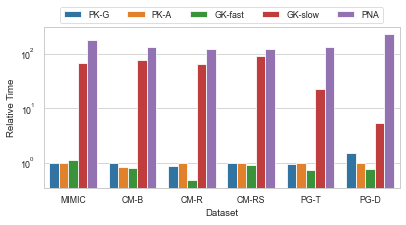

In [18]:
dataset_order = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]
selected_groups = ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
plot = sns.barplot(x="Dataset", y="Relative Time", hue="Group", order=dataset_order, hue_order=selected_groups, data=rel_time_df)
plot.set_yscale("log")
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plot.figure.set_size_inches(5.75, 3.25)
plt.tight_layout()

In [19]:
# saving the above plot
plot.figure.savefig("plots/best-performers-relative-timing.pdf")

### Figure 6: The mean classification accuracy of the best-performing provenance kernels, generic graph kernels, and PNA methods across the six classification tasks. The error bars show the 95-percent confidence intervals

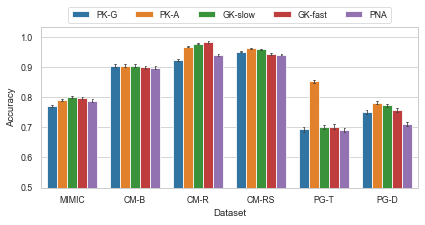

In [20]:
plt.figure()
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]
df = scorings[scorings.group_name.isin(set(selected_groups))]
plot = sns.barplot(x="dataset", y="accuracy", hue="group_name",
                   hue_order=selected_groups, data=df, palette=current_palette,
                   errwidth=0.8, capsize=0.02)
plot.set(xlabel="Dataset", ylabel="Accuracy")
plot.figure.set_size_inches(6, 3.25)
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plt.ylim(0.5)
plt.tight_layout()

In [21]:
plot.figure.savefig("plots/accuracy-best-performers.pdf")